In [21]:
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

df = pd.read_csv('air_quality_monthly_data.csv')
df['Month Start (UTC)'] = pd.to_datetime(df['Month Start (UTC)'])

# Predefined Categorizations
primary_categories = {
    'urban': ['Toronto Downtown', 'Downtown Vancouver', 'Edmonton Central Eas', 'Ottawa Downtown', 'Calgary Central2', 'Saskatoon', 'Regina', 'Winnipeg_Ellens', 'Kingston', 'Greystone Heights', 'SPARTAN - Halifax'],
    'wildfire-prone': ['Bonner Lake', 'Radisson', 'Chapais', 'Wood Buffalo Park', 'Snare Rapids', 'Fort Chipewyan', 'Buffalo Narrows', 'Pickle Lake', 'Experimental Lakes', 'R�s. Faun. Ashuapmus', 'Mont-Saint-Michel', 'Beausejour', 'Pinehouse Lake', 'Joussard', 'Beaverlodge', 'Vanderhoof Courthous', 'Burns Lake Fire Cent', 'Houston Firehall', 'Searchmont', 'Dorset', 'Parry Sound', 'Notre-Dame-du-Rosair', 'Auclair', 'FIREHALL-LABRADORCIT', 'Goose Bay'],
    'mixed': ['St-Dominique', 'Brandon', 'FREDERICTON', 'CHARLOTTETOWN', 'Thunder Bay', 'Rouyn-Noranda - Parc', 'Kelowna KLO Road', 'PRINCE ALBERT', 'Town of Peace River', 'Flin Flon', 'FORT ST JOHN LEARNIN', 'PRG Plaza 400', 'Quesnel Johnston Ave', 'Whitehorse NAPS', 'Smithers Muheim Memo', 'Courtenay Elementary', 'Sault Ste Marie', 'Sudbury', 'North Bay', 'Con Area Yellowknife', 'BATHURST', 'SYDNEY']
}

coastal_cities = ['Downtown Vancouver', 'SPARTAN - Halifax', 'CHARLOTTETOWN', 'SYDNEY', 'Courtenay Elementary', 'BATHURST', 'Goose Bay', 'FIREHALL-LABRADORCIT', 'Notre-Dame-du-Rosair']
inner_cities = [city for city in df['City'].unique() if city not in coastal_cities]
secondary_categories = {
    'coastal': coastal_cities,
    'inner': inner_cities
}

# Function to compute correlations for predefined categories
def compute_correlations(df, categories, period_name):
    pivot_df = df.pivot_table(index=['City', 'Month Start (UTC)'], 
                              columns='Sensor Parameter', 
                              values='Monthly Average').dropna()
    pivot_df = pivot_df[pivot_df['o₃'] >= 0]

    for cat, cities in categories.items():
        cat_df = pivot_df[pivot_df.index.get_level_values('City').isin(cities)]
        if not cat_df.empty:
            cat_corr = cat_df[['pm2.5', 'o₃']].corr().loc['pm2.5', 'o₃']
            logger.info(f"{period_name} Correlation for {cat} cities: {cat_corr}")
        else:
            logger.warning(f"No data for {cat} cities in {period_name}")

# Function to compute per-city correlations and group by strength
def group_by_correlation(df, period_name):
    pivot_df = df.pivot_table(index=['City', 'Month Start (UTC)'], 
                              columns='Sensor Parameter', 
                              values='Monthly Average').dropna()
    pivot_df = pivot_df[pivot_df['o₃'] >= 0]

    # Compute correlations for each city
    logger.info(f"Debug: Pivot_df shape before grouping: {pivot_df.shape}")
    city_corrs = pivot_df.groupby(level='City')[['pm2.5', 'o₃']].corr()
    logger.info(f"Debug: City_corrs shape after grouping: {city_corrs.shape}")
    city_corrs = city_corrs.loc[(slice(None), 'pm2.5'), 'o₃'].reset_index(name='Correlation')
    logger.info(f"Debug: City_corrs shape after reset_index: {city_corrs.shape}")
    logger.info(f"Debug: City_corrs head:\n{city_corrs.head()}")
    city_corrs = city_corrs[['City', 'Correlation']]
    city_corrs = city_corrs.set_index('City')
    logger.info(f"Debug: Final city_corrs shape: {city_corrs.shape}")

    # Define correlation bins
    bins = {
        'Strong Positive (>0.3)': lambda x: x > 0.3,
        'Weak Positive (0 to 0.3)': lambda x: (x >= 0) & (x <= 0.3),
        'Near Zero (-0.1 to 0)': lambda x: (x > -0.1) & (x < 0),
        'Weak Negative (-0.3 to -0.1)': lambda x: (x >= -0.3) & (x <= -0.1),
        'Strong Negative (<-0.3)': lambda x: x < -0.3
    }

    # Group cities by correlation strength
    for label, condition in bins.items():
        # Apply condition vectorized
        mask = condition(city_corrs['Correlation'])
        cities_in_bin = city_corrs.loc[mask].index.tolist()
        if cities_in_bin:
            logger.info(f"\n{period_name} - {label} Correlations:")
            for city in cities_in_bin:
                corr = city_corrs.loc[city, 'Correlation']
                logger.info(f"  {city}: {corr:.4f}")

# Analysis 1: Wildfire Season (May-Sep, 2018-2024)
wildfire_df = df[df['Month Start (UTC)'].dt.month.isin([5, 6, 7, 8, 9])]
wildfire_df = wildfire_df[wildfire_df['Month Start (UTC)'].dt.year.between(2018, 2024)]

logger.info("=== Wildfire Season Analysis (May-Sep, 2018-2024) ===")
logger.info("Primary Categorization (Urban/Wildfire-Prone/Mixed):")
compute_correlations(wildfire_df, primary_categories, "Wildfire Season")
logger.info("Secondary Categorization (Coastal/Inner):")
compute_correlations(wildfire_df, secondary_categories, "Wildfire Season")
logger.info("Grouping by Correlation Strength:")
group_by_correlation(wildfire_df, "Wildfire Season")

# Analysis 2: Full Year (2016-2025, up to March 07, 2025)
full_df = df[df['Month Start (UTC)'] <= pd.to_datetime('2025-03-07').tz_localize('UTC')]

logger.info("\n=== Full Year Analysis (2016-2025, up to March 07, 2025) ===")
logger.info("Primary Categorization (Urban/Wildfire-Prone/Mixed):")
compute_correlations(full_df, primary_categories, "Full Year")
logger.info("Secondary Categorization (Coastal/Inner):")
compute_correlations(full_df, secondary_categories, "Full Year")
logger.info("Grouping by Correlation Strength:")
group_by_correlation(full_df, "Full Year")

# Analysis 3: Non-Wildfire Season (Oct-Apr, 2016-2025, up to March 07, 2025)
non_wildfire_df = df[~df['Month Start (UTC)'].dt.month.isin([5, 6, 7, 8, 9])]
non_wildfire_df = non_wildfire_df[non_wildfire_df['Month Start (UTC)'] <= pd.to_datetime('2025-03-07').tz_localize('UTC')]

logger.info("\n=== Non-Wildfire Season Analysis (Oct-Apr, 2016-2025, up to March 07, 2025) ===")
logger.info("Primary Categorization (Urban/Wildfire-Prone/Mixed):")
compute_correlations(non_wildfire_df, primary_categories, "Non-Wildfire Season")
logger.info("Secondary Categorization (Coastal/Inner):")
compute_correlations(non_wildfire_df, secondary_categories, "Non-Wildfire Season")
logger.info("Grouping by Correlation Strength:")
group_by_correlation(non_wildfire_df, "Non-Wildfire Season")

# Yearly Trends (Full Year)
pivot_df = full_df.pivot_table(index=['City', 'Month Start (UTC)'], 
                               columns='Sensor Parameter', 
                               values='Monthly Average').dropna()
pivot_df = pivot_df[pivot_df['o₃'] >= 0]
pivot_df = pivot_df.reset_index()
pivot_df['Year'] = pivot_df['Month Start (UTC)'].dt.year
yearly_trends = pivot_df.groupby('Year')[['pm2.5', 'o₃']].mean()
logger.info(f"\nYearly Trends (Full Year):\n{yearly_trends.to_string()}")

2025-03-07 08:21:22,186 - INFO - === Wildfire Season Analysis (May-Sep, 2018-2024) ===
2025-03-07 08:21:22,186 - INFO - Primary Categorization (Urban/Wildfire-Prone/Mixed):
2025-03-07 08:21:22,199 - INFO - Wildfire Season Correlation for urban cities: 0.15373598930291793
2025-03-07 08:21:22,202 - INFO - Wildfire Season Correlation for wildfire-prone cities: 0.12816902456986023
2025-03-07 08:21:22,204 - INFO - Wildfire Season Correlation for mixed cities: -0.04987970555412289
2025-03-07 08:21:22,205 - INFO - Secondary Categorization (Coastal/Inner):
2025-03-07 08:21:22,219 - INFO - Wildfire Season Correlation for coastal cities: -0.007678006299925987
2025-03-07 08:21:22,221 - INFO - Wildfire Season Correlation for inner cities: 0.09461413986229429
2025-03-07 08:21:22,221 - INFO - Grouping by Correlation Strength:
2025-03-07 08:21:22,229 - INFO - Debug: Pivot_df shape before grouping: (742, 2)
2025-03-07 08:21:22,240 - INFO - Debug: City_corrs shape after grouping: (78, 2)
2025-03-07 08:

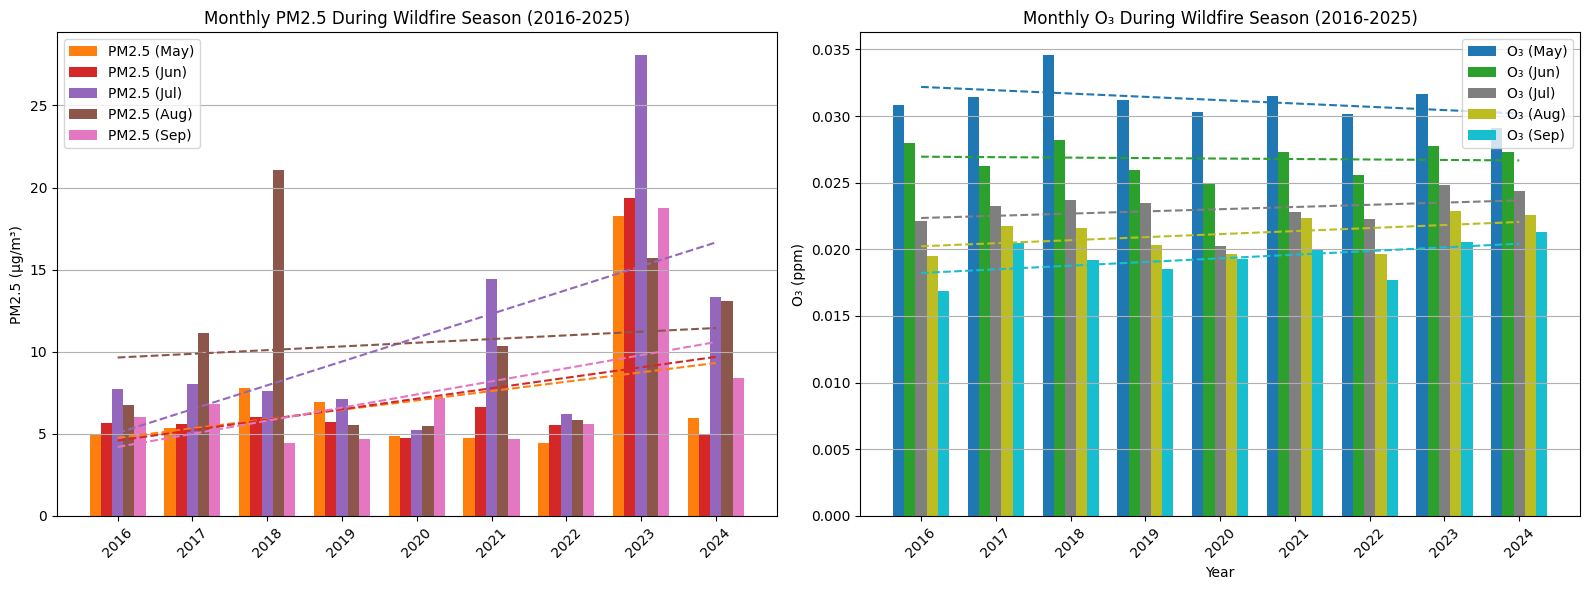

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Set up bar chart positions
bar_width = 0.15
years = monthly_trends.index.get_level_values(0).unique()
x = np.arange(len(years))

# Create figure with two subplots for PM2.5 and O₃
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for each month
colors_pm25 = ["#ff7f0e", "#d62728", "#9467bd", "#8c564b", "#e377c2"]
colors_o3 = ["#1f77b4", "#2ca02c", "#7f7f7f", "#bcbd22", "#17becf"]

# PM2.5 Bar Chart with Trendlines
axes[0].set_title("Monthly PM2.5 During Wildfire Season (2016-2025)")
for i, month in enumerate(fire_season_months):
    month_pm25 = monthly_trends.xs(month, level=1)["pm2.5"]
    axes[0].bar(x + (i - 2) * bar_width, month_pm25, bar_width, color=colors_pm25[i], label=f"PM2.5 ({pd.to_datetime(month, format='%m').strftime('%b')})")

    # Trendline
    slope, intercept, _, _, _ = linregress(years, month_pm25)
    trendline = slope * years + intercept
    axes[0].plot(x, trendline, linestyle="--", color=colors_pm25[i])

axes[0].set_xticks(x)
axes[0].set_xticklabels(years, rotation=45)
axes[0].set_ylabel("PM2.5 (µg/m³)")
axes[0].legend()
axes[0].grid(axis="y")

# O₃ Bar Chart with Trendlines
axes[1].set_title("Monthly O₃ During Wildfire Season (2016-2025)")
for i, month in enumerate(fire_season_months):
    month_o3 = monthly_trends.xs(month, level=1)["o₃"]
    axes[1].bar(x + (i - 2) * bar_width, month_o3, bar_width, color=colors_o3[i], label=f"O₃ ({pd.to_datetime(month, format='%m').strftime('%b')})")

    # Trendline
    slope, intercept, _, _, _ = linregress(years, month_o3)
    trendline = slope * years + intercept
    axes[1].plot(x, trendline, linestyle="--", color=colors_o3[i])

axes[1].set_xticks(x)
axes[1].set_xticklabels(years, rotation=45)
axes[1].set_ylabel("O₃ (ppm)")
axes[1].legend()
axes[1].grid(axis="y")

# Formatting
plt.xlabel("Year")
plt.tight_layout()
plt.show()


2025-03-07 13:45:14,733 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-07 13:45:14,735 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-07 13:45:14,736 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-07 13:45:14,738 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-07 13:45:14,739 - INFO - Using categorical units to plot a list of strings that are all parsable as 

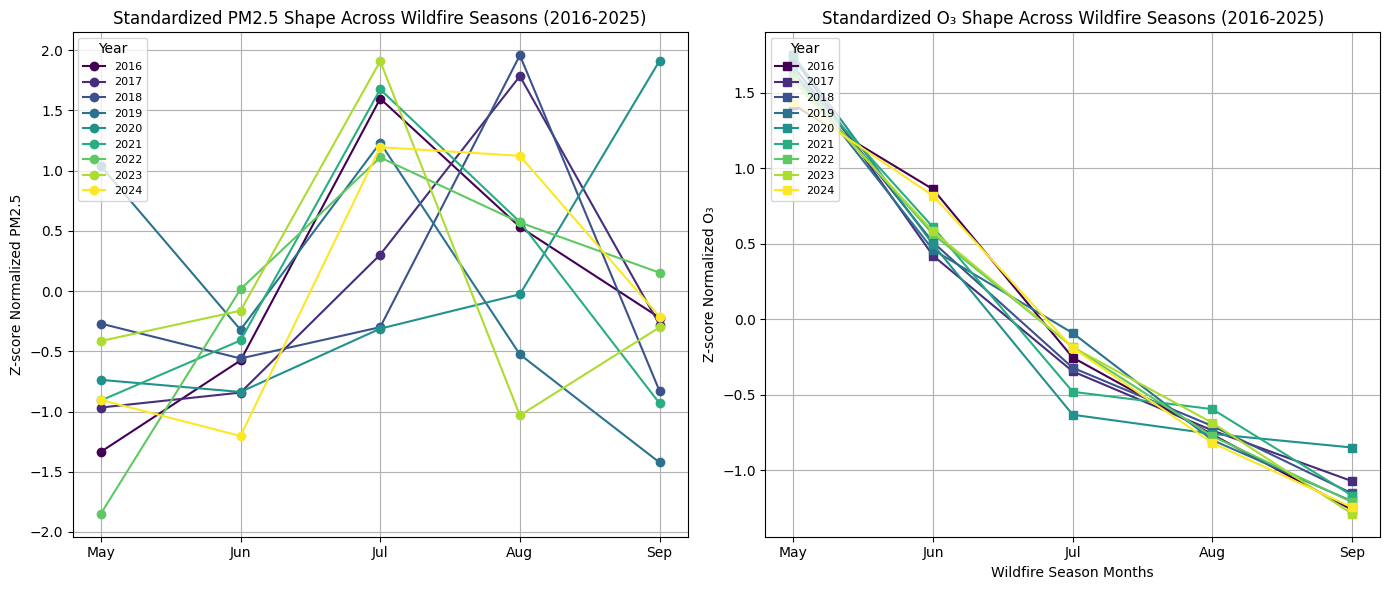

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Define wildfire season months
months = ["May", "Jun", "Jul", "Aug", "Sep"]

# Normalize PM2.5 and O₃ per year using z-score transformation
normalized_pm25 = monthly_trends["pm2.5"].groupby(level=0).transform(zscore)
normalized_o3 = monthly_trends["o₃"].groupby(level=0).transform(zscore)

# Get years and set up colormap (light to dark gradient)
years = normalized_pm25.index.get_level_values(0).unique()
cmap = plt.get_cmap("viridis", len(years))  # Using Viridis for a gradual color shift

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PM2.5 Plot with Gradient Colors
for i, year in enumerate(years):
    color = cmap(i / len(years))  # Assign color based on year index
    axes[0].plot(months, normalized_pm25.loc[year], marker="o", linestyle="-", label=str(year), color=color)
axes[0].set_title("Standardized PM2.5 Shape Across Wildfire Seasons (2016-2025)")
axes[0].set_ylabel("Z-score Normalized PM2.5")
axes[0].legend(loc="upper left", fontsize=8, title="Year")
axes[0].grid(True)

# O₃ Plot with Gradient Colors
for i, year in enumerate(years):
    color = cmap(i / len(years))
    axes[1].plot(months, normalized_o3.loc[year], marker="s", linestyle="-", label=str(year), color=color)
axes[1].set_title("Standardized O₃ Shape Across Wildfire Seasons (2016-2025)")
axes[1].set_ylabel("Z-score Normalized O₃")
axes[1].legend(loc="upper left", fontsize=8, title="Year")
axes[1].grid(True)

# Formatting
plt.xlabel("Wildfire Season Months")
plt.tight_layout()
plt.show()
